# **Import Libraries**

In [26]:
import numpy as np
import pandas as pd
import cv2
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from keras.layers import Flatten, Dense, Conv2D, MaxPooling2D, Dropout, DepthwiseConv2D, BatchNormalization, GlobalAveragePooling2D
from keras.models import Model, load_model
from keras.preprocessing.image import ImageDataGenerator 
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.applications import MobileNet
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.utils import plot_model
from IPython.display import Image
from keras.preprocessing import image
import os
sns.set()

# **Load Train Dataset**

In [27]:
train_datagen = ImageDataGenerator(
     zoom_range = 0.2, 
     shear_range = 0.2, 
     rotation_range=30,
     width_shift_range = 0.1,
     height_shift_range = 0.1,
     horizontal_flip=True,
     rescale = 1./255
)

train_data = train_datagen.flow_from_directory(directory= "/content/train", 
                                               target_size=(224,224), 
                                               batch_size=64,
                                               class_mode='categorical',
                                  )


train_data.class_indices

Found 28709 images belonging to 7 classes.


{'angry': 0,
 'disgust': 1,
 'fear': 2,
 'happy': 3,
 'neutral': 4,
 'sad': 5,
 'surprise': 6}

# **Load Test Dataset**

In [28]:
val_datagen = ImageDataGenerator(rescale = 1./255 )

val_data = val_datagen.flow_from_directory(directory= "/content/test", 
                                           target_size=(224,224), 
                                           batch_size=64,
                                           class_mode='categorical',
                                  )

Found 7178 images belonging to 7 classes.


# **Countplot**

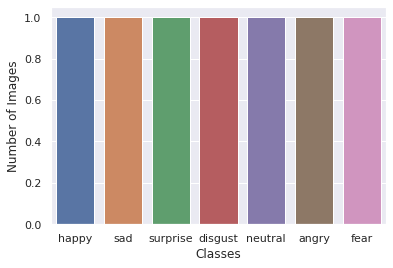

In [29]:
path = '/content/train'

class_counts = {}

for subdir in os.listdir(path):
    subdir_path = os.path.join(path, subdir)
    class_counts[subdir] = len(os.listdir(subdir_path))

sns.countplot(x=list(class_counts.keys()), data=None)
plt.xlabel('Classes')
plt.ylabel('Number of Images')
plt.show()


# **Visualize Images**

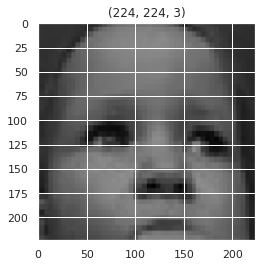

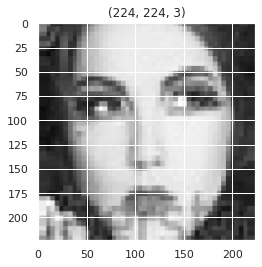

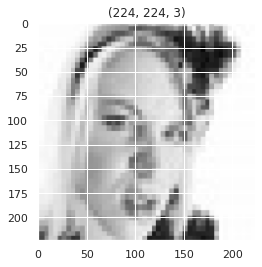

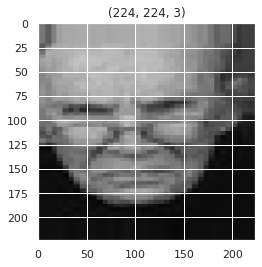

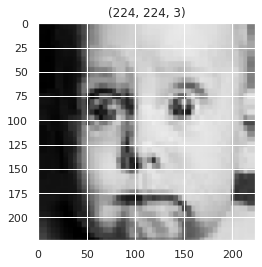

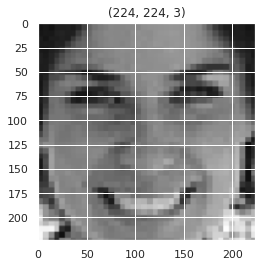

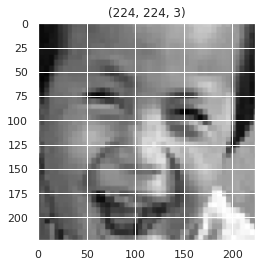

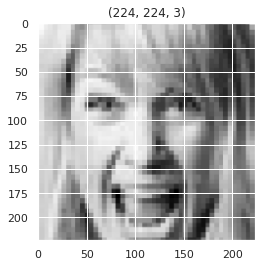

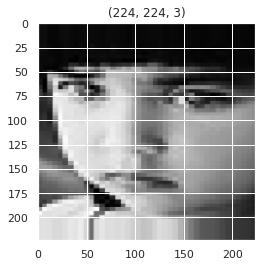

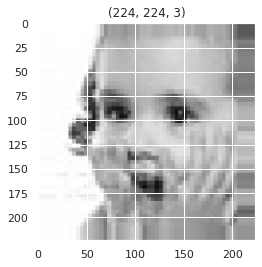

In [ ]:
t_img , label = train_data.next()

def plotImages(img_arr, label):

  count = 0
  for im, l in zip(img_arr,label) :
    plt.imshow(im)
    plt.title(im.shape)
    plt.axis = False
    plt.show()
    
    count += 1
    if count == 10:
      break

plotImages(t_img, label)

# **Model Building**

In [ ]:
base_model = MobileNet( weights = 'imagenet', input_shape = (224,224,3), include_top = False )

for layer in base_model.layers[:-10]:
    layer.trainable = False

for layer in base_model.layers[-10:]:
    layer.trainable = True

x = base_model.output
x= Conv2D(filters = 32, kernel_size = (1,1), strides = (1,1), activation = 'relu', padding = 'same')(x)

x= Conv2D(filters = 64, kernel_size = (3,3), activation = 'relu', padding = 'same')(x)

x= Conv2D(filters = 128, kernel_size = (3,3), activation = 'relu', padding = 'same')(x)

x= Conv2D(filters = 256, kernel_size = (3,3), activation = 'relu', padding = 'same')(x)

x= Conv2D(filters = 512, kernel_size = (3,3), activation = 'relu', padding = 'same')(x)

x= GlobalAveragePooling2D()(x)

x = Flatten()(x)

x = Dense(units = 256 , activation = 'relu' )(x)
x= Dropout(0.3)(x)

x = Dense(units = 512 , activation = 'relu' )(x)
x= Dropout(0.3)(x)

x = Dense(units=7 , activation = 'softmax' )(x)

model = Model(base_model.input, outputs = x)

17225924/17225924 [==============================] - 0s 0us/step


In [ ]:
model.compile(optimizer='adam', loss='categorical_crossentropy' , metrics=['accuracy']  )
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv1 (Conv2D)              (None, 112, 112, 32)      864       
                                                                 
 conv1_bn (BatchNormalizatio  (None, 112, 112, 32)     128       
 n)                                                              
                                                                 
 conv1_relu (ReLU)           (None, 112, 112, 32)      0         
                                                                 
 conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)     288       
                                                                 
 conv_dw_1_bn (BatchNormaliz  (None, 112, 112, 32)     128       
 ation)                                                      

# **Model Training**

In [ ]:
checkpoint = ModelCheckpoint(filepath="best_model.h5", monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')

early_stopping = EarlyStopping(monitor='val_accuracy',
                          min_delta=0.01,
                          patience=10,
                          verbose=1,
                          restore_best_weights=True
                          )

reduce_learningrate = ReduceLROnPlateau(monitor='val_loss',
                              factor=0.2,
                              patience=3,
                              verbose=1,
                              min_delta=0.0001)

callbacks_list = [early_stopping,checkpoint,reduce_learningrate]

In [ ]:
hist = model.fit(train_data, epochs = 25, validation_data = val_data, callbacks = callbacks_list)

Epoch 1/25
449/449 [==============================] - ETA: 0s - loss: 1.4118 - accuracy: 0.4559
Epoch 1: val_accuracy improved from -inf to 0.30287, saving model to best_model.h5
449/449 [==============================] - 353s 748ms/step - loss: 1.4118 - accuracy: 0.4559 - val_loss: 1.9731 - val_accuracy: 0.3029 - lr: 0.0010
Epoch 2/25
449/449 [==============================] - ETA: 0s - loss: 1.1953 - accuracy: 0.5547
Epoch 2: val_accuracy improved from 0.30287 to 0.50279, saving model to best_model.h5
449/449 [==============================] - 332s 739ms/step - loss: 1.1953 - accuracy: 0.5547 - val_loss: 1.3112 - val_accuracy: 0.5028 - lr: 0.0010
Epoch 3/25
449/449 [==============================] - ETA: 0s - loss: 1.1205 - accuracy: 0.5868
Epoch 3: val_accuracy did not improve from 0.50279
449/449 [==============================] - 325s 724ms/step - loss: 1.1205 - accuracy: 0.5868 - val_loss: 1.3420 - val_accuracy: 0.4928 - lr: 0.0010
Epoch 4/25
449/449 [============================

# **Model Save**

In [ ]:

model = load_model('Emotion_Detection.h5')

# *Plotting Accuracy and Loss*

In [ ]:
h =  hist.history
h.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy', 'lr'])

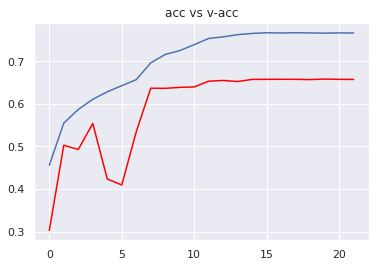

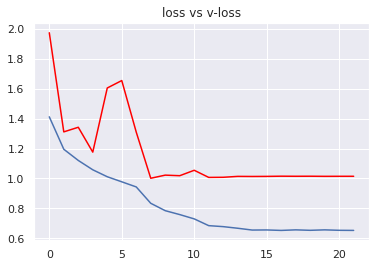

In [ ]:
plt.plot(h['accuracy'])
plt.plot(h['val_accuracy'] , c = "red")
plt.title("acc vs v-acc")
plt.show()
plt.plot(h['loss'])
plt.plot(h['val_loss'] , c = "red")
plt.title("loss vs v-loss")
plt.show()

# **Prediction**

In [ ]:
op = dict(zip( train_data.class_indices.values(), train_data.class_indices.keys()))
print(op)

{0: 'angry', 1: 'disgust', 2: 'fear', 3: 'happy', 4: 'neutral', 5: 'sad', 6: 'surprise'}


1/1 [==============================] - 0s 26ms/step
 The image is of disgust


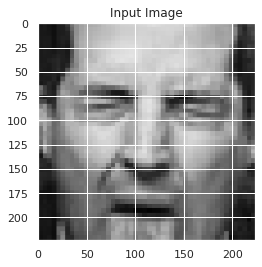

In [ ]:
# path for the image to see if it predics correct class

path = "/content/test/disgust/PrivateTest_89077668.jpg"
img = load_img(path, target_size=(224,224) )

i = img_to_array(img)/255
input_arr = np.array([i])
input_arr.shape

pred = np.argmax(model.predict(input_arr))

print(f" The image is of {op[pred]}")
  
plt.imshow(input_arr[0])
plt.title("Input Image")
plt.show()